In [76]:
# This is the data i'm working with, word2vec essentially
# looks at the meaningful words that are next to each other
# and tries to put them closer togetoher in a many dimensional
# space
sentences = [
    "king is a strong man", 
    "queen is a wise woman", 
    "boy is a young man", 
    "girl is a young woman", 
    "prince is a young king", 
    "princess is a young queen", 
    "man is strong", 
    "woman is wise", 
    "prince is a boy who will be king", 
    "princess is a girl who will be queen"
]

In [77]:
# various libraries i'm using, mostly just tensorflow and a plotting library
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import random

In [78]:
# This function looks at a string and returns a list of meaningful words and not junk words
# I don't care to get in the way of the comparison of nearby neighbors
def getUsefulWords(sentence):
    allWords = sentence.split()
    allDistinctWords = set(allWords)
    uselessWords = {"the","is","be","will","a","becomes","who"}
    allDistinctUsefulWords = list(filter(lambda a: a not in uselessWords, allDistinctWords))
    return allDistinctUsefulWords

# take in a sequence of words and generate a list of all the words that appear side by side
# i.e. ["a","b","c"] -> [["a","b"],["b","c"],["b","c"],["c","b"]]
def getNeighbors(wordSequence):
    neighbors = []
    # if we only have one word we have no neighbors
    if len(wordSequence) == 1:
        return neighbors
    for i,_ in enumerate(wordSequence):
        if i != 0:
            neighbors.append([wordSequence[i],wordSequence[i-1]])
        if i != len(wordSequence)-1:
            neighbors.append([wordSequence[i],wordSequence[i+1]])
    return neighbors

# get the list of all unique words from all sentences
allSentenceWordLists = list(map(lambda s: getUsefulWords(s) , sentences))
allUniqueWords = set([item for sublist in allSentenceWordLists for item in sublist])
vocab_size = len(allUniqueWords)

print("All Words:\n",allUniqueWords)

# hot encodings work by giving a unique unit vector to a single item of a set of items
# for instance, if I had a list of 5 items, i'd be creating 5-dimensional vectors
# and the vector of the first item would be [1,0,0,0,0]
# we'll use this to help create the input data of our neural network
def makeHotEncoding(index):
    arr = [0]*len(allUniqueWords)
    arr[index] = 1
    return arr

# get the hot encodings for all words
hotEncodings = {element: makeHotEncoding(i) for i,element in enumerate(allUniqueWords)} 

# get all our neighbors from all sentences
allSentenceNeighborLists = list(map(lambda s: getNeighbors(getUsefulWords(s)) , sentences))
allNeighbors = [item for sublist in allSentenceNeighborLists for item in sublist]
# create some randomness in the order of neighbors to vary input order
random.shuffle(allNeighbors)

print("Words we are trying to associate:\n",allNeighbors)

inputs = tf.convert_to_tensor(list(map(lambda s: hotEncodings[s[0]], allNeighbors)),dtype=tf.float32)
outputs = tf.convert_to_tensor(list(map(lambda s:hotEncodings[s[1]], allNeighbors)),dtype=tf.float32)

All Words:
 {'king', 'man', 'queen', 'young', 'princess', 'wise', 'woman', 'boy', 'strong', 'girl', 'prince'}
Words we are trying to associate:
 [['king', 'prince'], ['woman', 'wise'], ['boy', 'king'], ['strong', 'man'], ['queen', 'girl'], ['king', 'boy'], ['man', 'young'], ['girl', 'woman'], ['prince', 'boy'], ['queen', 'young'], ['young', 'woman'], ['strong', 'king'], ['strong', 'man'], ['princess', 'girl'], ['woman', 'wise'], ['woman', 'young'], ['prince', 'king'], ['princess', 'queen'], ['woman', 'queen'], ['wise', 'woman'], ['girl', 'queen'], ['man', 'strong'], ['boy', 'prince'], ['man', 'strong'], ['young', 'queen'], ['woman', 'girl'], ['boy', 'young'], ['queen', 'princess'], ['young', 'man'], ['king', 'strong'], ['young', 'king'], ['wise', 'woman'], ['young', 'boy'], ['king', 'young'], ['girl', 'princess'], ['queen', 'woman']]


In [79]:
# We are trying to reduce the dimensions of our words down to 2D so we can easily visualize
encoding_dimension_size = 2

# Build the nueral network
model = keras.Sequential([
  # reduce the dimensions of our input word representations down to 2D
  layers.Dense(encoding_dimension_size, activation='relu', input_shape=(vocab_size,)),
  # Output back to our word dimension size so we can verify against the word we are trying
  # to train a relationship to
  layers.Dense(vocab_size, activation='softmax')
])

# Adam tries to reduce the error between our model's function and the real output
# using a bit of physical inertia so we don't hit local minima
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Let's see what tensorflow thinks is about to happen
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 2)                 24        
_________________________________________________________________
dense_25 (Dense)             (None, 11)                33        
Total params: 57
Trainable params: 57
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Run the nueral network
history = model.fit(
    inputs,
    outputs,
    epochs=1000,
    batch_size=512,
    validation_split=0.01)

In [81]:
# Let's get the weights of the 2nd layer of neurons
# to get our 2 dimensions representations of words
e = model.layers[0]
weights = e.get_weights()[0]
# make this easy to look through
lookup = list(map(lambda s: {'name':s[0],'x':s[1][0],'y':s[1][1]}, zip(allUniqueWords,weights)))
print(lookup)

[{'y': -0.8014396, 'name': 'king', 'x': 0.77166194}, {'y': -0.8723425, 'name': 'man', 'x': 1.0134928}, {'y': -0.8721942, 'name': 'queen', 'x': -0.5255586}, {'y': 0.5433546, 'name': 'young', 'x': -0.4609485}, {'y': -0.5392414, 'name': 'princess', 'x': -0.70445645}, {'y': 1.2947183, 'name': 'wise', 'x': 0.7240703}, {'y': -0.87188804, 'name': 'woman', 'x': -0.70401496}, {'y': 0.20645225, 'name': 'boy', 'x': 1.3195058}, {'y': 1.5303205, 'name': 'strong', 'x': -0.70410156}, {'y': 0.5102995, 'name': 'girl', 'x': -0.42409754}, {'y': 0.6063022, 'name': 'prince', 'x': 0.6188046}]


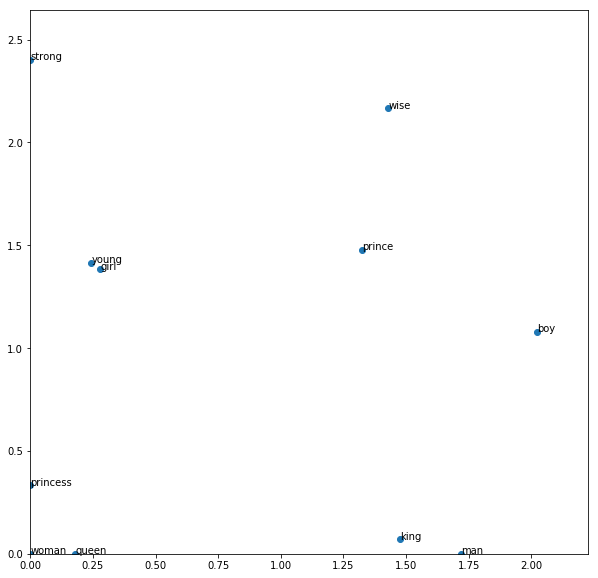

In [82]:
# Draw these words in 2d chart
fig, ax = plt.subplots()
x_min = 0
y_min = 0
x_max = 0
y_max = 0
x_data = []
y_data = []
for e in lookup:
    x_min = min(x_min,e['x'])
    y_min = min(y_min,e['y'])
    x_max = max(x_max,e['x'])
    y_max = max(y_max,e['y'])
    
# let's shift things into positive quadrant to easily see origin
x_min = min(x_min,0)
y_min = min(y_min,0)
for e in lookup:
    x_data.append(e['x']-x_min)
    y_data.append(e['y']-y_min)
    # put labels wwhere appropriate
    ax.annotate(e['name'],(e['x']-x_min,e['y']-y_min))
x_pad = abs(x_max-x_min)*.1
y_pad = abs(y_max-y_min)*.1
    
# define how we want things to look
plt.xlim(0,x_max-x_min+x_pad)
plt.ylim(0,y_max-y_min+y_pad)
plt.rcParams["figure.figsize"] = (10,10)

# Make sure we draw the points too!
plt.scatter(x_data,y_data)